In [1]:
import geopandas
import geopandas as gpd
import pandas as pd
from osgeo import ogr,gdal
import numpy 
from shapely.wkb import loads
import pygeos
import matplotlib.pyplot as plt
import openpyxl
import itertools
import networkx as nx
from simplify import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
gdal.SetConfigOption("OSM_CONFIG_FILE", "osmconf.ini")

# Define a helper function to generate pairs of consecutive elements in a list
def pairwise(iterable):
    "s -> (s0, s1), (s1, s2), (s2, s3), ..."
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b)


# Define a helper function to generate permutations
def permutations(iterable, r=None):
   # permutations('ABCD', 2) --> AB AC AD BA BC BD CA CB CD DA DB DC
    # permutations(range(3)) --> 012 021 102 120 201 210
    pool = tuple(iterable)
    n = len(pool)
    r = n if r is None else r
    if r > n:
        return
    indices = list(range(n))
    cycles = list(range(n, n-r, -1))
    yield tuple(pool[i] for i in indices[:r])
    while n:
        for i in reversed(range(r)):
            cycles[i] -= 1
            if cycles[i] == 0:
                indices[i:] = indices[i+1:] + indices[i:i+1]
                cycles[i] = n - i
            else:
                j = cycles[i]
                indices[i], indices[-j] = indices[-j], indices[i]
                yield tuple(pool[i] for i in indices[:r])
                break
        else:
            return 
        
        
# Retrive data from OSM and get the geographic data of subway
def query_b(geoType,keyCol,**valConstraint):
    """
    This function builds an SQL query from the values passed to the retrieve() function.
    Arguments:
         *geoType* : Type of geometry (osm layer) to search for.
         *keyCol* : A list of keys/columns that should be selected from the layer.
         ***valConstraint* : A dictionary of constraints for the values. e.g. WHERE 'value'>20 or 'value'='constraint'
    Returns:
        *string: : a SQL query string.
    """
    query = "SELECT " + "osm_id"
    for a in keyCol: query+= ","+ a  
    query += " FROM " + geoType + " WHERE "
    # If there are values in the dictionary, add constraint clauses
    if valConstraint: 
        for a in [*valConstraint]:
            # For each value of the key, add the constraint
            for b in valConstraint[a]: query += a + b
        query+= " AND "
    # Always ensures the first key/col provided is not Null.
    query+= ""+str(keyCol[0]) +" IS NOT NULL" 
    return query 

def retrieve(osm_path,geoType,keyCol,**valConstraint):
    """
    Function to extract specified geometry and keys/values from OpenStreetMap
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region 
        for which we want to do the analysis.     
        *geoType* : Type of Geometry to retrieve. e.g. lines, multipolygons, etc.
        *keyCol* : These keys will be returned as columns in the dataframe.
        ***valConstraint: A dictionary specifiying the value constraints.  
        A key can have multiple values (as a list) for more than one constraint for key/value.  
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all columns, geometries, and constraints specified.    
    """
    driver=ogr.GetDriverByName('OSM')
    data = driver.Open(osm_path)
    query = query_b(geoType,keyCol,**valConstraint)
    sql_lyr = data.ExecuteSQL(query)
    features =[]
    # cl = columns 
    cl = ['osm_id']
    
    
    for a in keyCol: cl.append(a)
    if data is not None:
        for feature in sql_lyr:
            try:
                if feature.GetField(keyCol[0]) is not None:
                    pygeos_geo = pygeos.from_wkt(feature.geometry().ExportToWkt())
                    if pygeos_geo is None:
                        continue
                    # field will become a row in the dataframe.
                    field = []
                    for i in cl: field.append(feature.GetField(i))
                    field.append(pygeos_geo)   
                    features.append(field)
            except:
                print("WARNING: skipped OSM feature")
      
    cl.append('geometry')                   
    if len(features) > 0:
        return geopandas.GeoDataFrame(features,columns=cl) #,crs={'init': 'epsg:4326'}
    else:
        print("WARNING: No features or No Memory. returning empty GeoDataFrame") 
        return geopandas.GeoDataFrame(columns=['osm_id','geometry']) #,crs={'init': 'epsg:4326'}
    
def railway(osm_path):
    """
    Function to extract railway linestrings from OpenStreetMap
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region 
        for which we want to do the analysis.       
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all unique land-use polygons.
    """ 
    return retrieve(osm_path,'lines',['railway','service'])

def subway_network(osm_path):
    """
    Extract subway network information from an OpenStreetMap XML file.

    Args:
    - osm_path: a string representing the path to the OpenStreetMap XML file

    Returns:
    - a pandas DataFrame containing information about subway railways in the OpenStreetMap data

    Example:
    >>> import pandas as pd
    >>> osm_path = 'path/to/osm/file.xml'
    >>> subway_network = subway_network(osm_path)
    >>> print(subway_network.head())
          osmid        name        railway  ...    ref tunnel        geometry
    1234  1234    Line 1    subway   ...  M1    yes  LINESTRING (0.0 0.0, 1.0 1.0)
    5678  5678    Line 2    subway   ...  M2    yes  LINESTRING (1.0 1.0, 2.0 2.0)

    Note: This function requires the osmnx library to be installed and OpenStreetMap data with railway information to be available.
    """
    # Use the osmnx library to extract railway information from the OpenStreetMap data
    df_railway = railway(osm_path)
    
    # Filter the DataFrame to include only subway railways
    subway = df_railway.loc[df_railway.railway == 'subway']
    
    return subway


def train_stations(osm_path):
    """
    Function to extract big communication tower nodes from OpenStreetMap. See detailed information big communication towers: https://wiki.openstreetmap.org/wiki/Tag:man_made%3Dcommunications_tower   
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region for which we want to do the analysis.       
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all unique big communication tower nodes.
    """   
    
    return (retrieve(osm_path,'points',['railway', 'name'],**{'railway':["='station'"]}))
            #(retrieve(osm_path,'points',['railway'],**{'railway':["='station'"]}))
            #(retrieve(osm_path,'points',['man_made'],**{'man_made':["='communications_tower'"]})).rename(columns={'man_made': 'asset'})
        
        
def tram_network(osm_path):
    
    df_railway = railway(osm_path)
    
    tram = df_railway.loc[df_railway.railway == 'tram']
    return tram
    

def tram_stations(osm_path):
    """
    Function to extract big communication tower nodes from OpenStreetMap. See detailed information big communication towers: https://wiki.openstreetmap.org/wiki/Tag:man_made%3Dcommunications_tower   
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region for which we want to do the analysis.       
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all unique big communication tower nodes.
    """   
    
    return (retrieve(osm_path,'points',['railway', 'name'],**{'railway':["='tram_stop'"]}))


# Pre-processing the geographic data of the subway network to obtain 'edges' and 'nodes'
def prepare_network(subway):
    """
    Prepare a subway network represented as a GeoDataFrame of LineString objects for routing.

    Args:
    - subway: a GeoDataFrame representing the subway network, with 'geometry' column containing LineString objects
    
    Returns:
    - a tuple of two DataFrames representing the edges and nodes of the prepared network

    Example:
    >>> import geopandas
    >>> subway = geopandas.read_file('subway.shp')
    >>> edges, nodes = prepare_network(subway)

    Note: This function requires the PyGEOS, NetworkX, and Pandas libraries to be installed.
    """
    # Convert the subway GeoDataFrame's 'geometry' column from Shapely objects to PyGEOS objects
    df_subway = pd.DataFrame(subway.copy())
    df_subway.geometry = pygeos.from_shapely(df_subway.geometry)
    
    # Build a Network object from the subway edges
    net = Network(edges=df_subway)

    # Add endpoints to the network where edges don't intersect
    net = add_endpoints(net)

    # Split edges at new endpoints
    net = split_edges_at_nodes(net)

    # Add new endpoints where edges were split
    net = add_endpoints(net)

    # Assign unique IDs to nodes and edges
    net = add_ids(net)

    # Add missing topology information to the network's edges
    net = add_topology(net)    

    # Calculate the degree of each node in the network
    net.nodes['degree'] = calculate_degree(net)

    # Merge edges with a degree of 2
    net = merge_edges(net)

    # Drop duplicate edges
    net.edges = drop_duplicate_geometries(net.edges, keep='first') 

    # Reset node and edge IDs after fixing topology and merging edges
    net = reset_ids(net) 

    # Add edge distances
    net = add_distances(net)

    # Merge any MultiLineString edges
    net = merge_multilinestrings(net)

    # Add travel time for each edge based on distance and average speed
    net = add_travel_time(net)
    
    # Return the edges and nodes of the prepared network
    return net.edges, net.nodes

def expand_edges(edges):
    """
    Expand a DataFrame of edges into a format that can be used with network analysis algorithms.

    Args:
    - edges: a DataFrame containing edges with columns 'from_id', 'to_id', and 'distance'

    Returns:
    - a DataFrame containing expanded edges with columns 'from_id', 'to_id', 'distance', 'weights', 'to_from', and 'from_to'

    Example:
    >>> edges = pd.DataFrame({'from_id': [0, 0, 1], 'to_id': [1, 2, 2], 'distance': [1.5, 3.2, 2.8]})
    >>> expand_edges(edges)
      from_id  to_id  distance  weights  to_from  from_to
    0       0      1       1.5        1  (0, 1)  (1, 0)
    1       0      2       3.2        3  (0, 2)  (2, 0)
    2       1      2       2.8        2  (1, 2)  (2, 1)

    Notes:
    - The 'weights' column is created by rounding the 'distance' column to the nearest integer.
    - The 'to_from' and 'from_to' columns are created to facilitate conversion between edge formats.
    """
    # Round the distance to the nearest integer and store it in a new column 'weights'
    edges['weights'] = edges['distance'].astype(int)

    # Create 'to_from' and 'from_to' columns to facilitate conversion between edge formats
    edges['to_from'] = list(zip(edges.from_id, edges.to_id))
    edges['from_to'] = list(zip(edges.to_id, edges.from_id))

    # Return the expanded edges DataFrame
    return edges


# Create a base Graph object as the basic topology network with 'edges' and 'nodes'
def create_ground_graph(edges, nodes):
    """
    Create a networkx Graph object representing a ground transportation network.

    Args:
    - edges: a pandas DataFrame containing edges in the network, with columns 'from_id', 'to_id', and 'weights'
    - nodes: a GeoDataFrame containing nodes in the network, with a 'geometry' column representing their coordinates as PyGEOS Point objects
    
    Returns:
    - a networkx Graph object representing the ground transportation network

    Example:
    >>> import pandas as pd
    >>> import geopandas as gpd
    >>> import networkx as nx
    >>> edges = pd.read_csv('edges.csv')
    >>> nodes = gpd.read_file('nodes.shp')
    >>> G = create_ground_graph(edges, nodes)

    Note: This function requires the pandas, geopandas, and networkx libraries to be installed.
    """
    # Extract the edges from the input DataFrame and create a list of tuples with weights
    od = edges[['from_id', 'to_id', 'weights']]
    edges_list = []
    for i, row in od.iterrows():
        weight_dict = {"weight": row[2]}
        tuple_row = (row[0], row[1], weight_dict)
        edges_list.append(tuple_row)
    
    # Extract the nodes from the input GeoDataFrame and create a list of node IDs
    nodes_list = nodes.iloc[:,2].tolist()
    
    # Create an empty Graph object and add the nodes and edges
    G = nx.Graph()
    G.add_nodes_from(nodes_list)
    G.add_edges_from(edges_list)
    
    return G


# Create coordinates of random start and end points in the research area
def create_grid(bbox, height):
    """Create a vector-based grid.

    Args:
        bbox: A tuple or list containing the bounding box coordinates as (xmin, ymin, xmax, ymax).
        height: The size of the grid.

    Returns:
        A PyGEOS polygon object representing the grid.

    """

    # Set xmin, ymin, xmax, and ymax of the grid
    xmin, ymin = pygeos.total_bounds(bbox)[0], pygeos.total_bounds(bbox)[1]
    xmax, ymax = pygeos.total_bounds(bbox)[2], pygeos.total_bounds(bbox)[3]
    
    # Estimate total rows and columns
    rows = int(np.ceil((ymax-ymin) / height))
    cols = int(np.ceil((xmax-xmin) / height))

    # Set corner points
    x_left_origin = xmin
    x_right_origin = xmin + height
    y_top_origin = ymax
    y_bottom_origin = ymax - height

    # Create actual grid
    res_geoms = []
    for countcols in range(cols):
        y_top = y_top_origin
        y_bottom = y_bottom_origin
        for countrows in range(rows):
            # Append the four corner points of each cell to the list
            res_geoms.append((
                ((x_left_origin, y_top), (x_right_origin, y_top),
                 (x_right_origin, y_bottom), (x_left_origin, y_bottom)
                )))
            y_top = y_top - height
            y_bottom = y_bottom - height
        x_left_origin = x_left_origin + height
        x_right_origin = x_right_origin + height

    # Convert the list of corner points into a PyGEOS polygon object
    return pygeos.polygons(res_geoms)

def coordinates_pairs(create_grid):
    """
    Generates a pandas DataFrame of all possible coordinate pairs between grid center points.

    Args:
    - create_grid: a GeoDataFrame containing the grid polygons, with a 'geometry' column representing their coordinates as PyGEOS Polygon objects.

    Returns:
    - A pandas DataFrame containing all possible coordinate pairs as PyGEOS Point objects. 
    - The DataFrame has two columns: 's_coordinates' and 'e_coordinates', which represent the starting and ending coordinates of each pair, respectively.

    Example:
    >>> import geopandas as gpd
    >>> import pandas as pd
    >>> import pygeos
    >>> import itertools
    >>> create_grid = gpd.read_file('grid.shp')
    >>> coord_pairs = coordinates_pairs(create_grid)

    Note: This function requires the geopandas, pandas, pygeos, and itertools libraries to be installed.
    """
    # Calculate the centroid of each grid polygon and store them in a new GeoDataFrame
    grid_center_coordinates = gpd.GeoDataFrame(pygeos.centroid(create_grid.geometry.values),columns=['geometry'])
    
    # Create a new GeoDataFrame containing all possible pairs of coordinates from the grid centroids
    coordinates_pairs = gpd.GeoDataFrame(itertools.permutations(grid_center_coordinates.geometry, 2), columns=['s_coordinates', 'e_coordinates'])
    
    # Convert the GeoDataFrame to a pandas DataFrame and return a copy of the DataFrame
    return pd.DataFrame(coordinates_pairs.copy())


# Define nearest nodes with real_world coordinates of start and end points, obtain the nearest id pairs of nodes 
def find_nearest_node(coordinate, nodes):
    """
    Find the nearest node to a given coordinate or geometry in a GeoDataFrame of nodes.

    Args:
    - coordinate: a tuple of longitude and latitude (in decimal degrees) or a PyGEOS geometry object representing the location to search from
    - nodes: a GeoDataFrame containing nodes with a 'geometry' column representing their coordinates as PyGEOS Point objects
    
    Returns:
    - the id value of the nearest node to the input coordinate or geometry

    Example:
    >>> import geopandas
    >>> from shapely.geometry import Point
    >>> from pygeos import Geometry
    >>> nodes = geopandas.read_file('nodes.shp')
    >>> coordinate = (-122.3, 47.6)
    >>> find_nearest_node(coordinate, nodes)
    1234

    Note: This function requires the PyGEOS and STRtree libraries to be installed.
    """
    # Build an STRtree index of the nodes' geometries for efficient nearest-neighbor search
    node_tree = pygeos.STRtree(nodes.geometry)
   
    # Find the nearest node to the input coordinate or geometry using the STRtree index
    if isinstance(coordinate, tuple):
        find_nearest = node_tree.nearest(pygeos.points(coordinate))
    elif isinstance(coordinate, pygeos.lib.Geometry):
        find_nearest = node_tree.nearest(coordinate)
    
    # Return the id value of the nearest node from the nodes GeoDataFrame
    return int(nodes.iloc[find_nearest[1]]['id'])


def id_pairs(coordinates_pairs, nodes):
    """
    Map the start and end coordinates to the nearest nodes in a transportation network.

    Args:
    - coordinates_pairs: a pandas DataFrame containing start and end coordinates in the network, with columns 's_coordinates', 'e_coordinates'
    - nodes: a GeoDataFrame containing nodes in the network, with a 'geometry' column representing their coordinates as PyGEOS Point objects

    Returns:
    - a pandas DataFrame containing the nearest node IDs for each start and end coordinate pair, with columns 's_id', 'e_id'

    """
    # Initialize an empty DataFrame to store the start and end node IDs
    id_pairs = pd.DataFrame(columns=['s_id','e_id'])
    pairs_num = coordinates_pairs.shape[0]
    
    # For each start and end coordinate pair, find the nearest node in the network and store the node IDs in the DataFrame
    for i in range(pairs_num):
        s_coordinate = pygeos.points(coordinates_pairs.s_coordinates[i])
        s_id = find_nearest_node(s_coordinate, nodes)
        e_coordinate = pygeos.points(coordinates_pairs.e_coordinates[i])
        e_id = find_nearest_node(e_coordinate, nodes)
        id_pairs.loc[i] = [s_id,e_id]
        
    return id_pairs


# Calculate the shorted path
def shortest_path(G, start_point_id, end_point_id, edges, weight = "weight"):   # calculate the shortest path for one start_end_node id_pair
    """
    Compute the shortest path between two nodes in a given graph, along with its length and the edges that belong to the path.

    Args:
    - G: a networkx Graph object representing the graph
    - start_point_id: the ID of the node where the path starts
    - end_point_id: the ID of the node where the path ends
    - weight: the attribute used to determine the weight of the edges in the graph (default: "weight")

    Returns:
    - a tuple containing:
        - the list of nodes that form the shortest path from start_point_id to end_point_id
        - the length of the shortest path
        - a pandas DataFrame containing the edges that belong to the shortest path, with a new column 'linewidth' that is proportional to the edge weights

    Example:
    >>> import networkx as nx
    >>> import pandas as pd
    >>> G = nx.Graph()
    >>> G.add_edge(0, 1, weight=2.0)
    >>> G.add_edge(1, 2, weight=1.0)
    >>> G.add_edge(0, 2, weight=3.0)
    >>> path, length, edges = shortest_path(G, 0, 2)
    >>> print(path)
    [0, 1, 2]
    >>> print(length)
    3.0
    >>> print(edges)
       from_id  to_id  weights  to_from  from_to  linewidth
    0        0      1      2.0      NaN      1.0        1.0
    2        1      2      1.0      2.0      NaN        1.0
    """
    
    # Compute the shortest path and its length using the networkx library
    path_s_e = nx.shortest_path(G, source=start_point_id, target=end_point_id, weight= weight)
    length_s_e = nx.shortest_path_length(G, source=start_point_id, target=end_point_id, weight= weight)
    
   
    # Select the edges that belong to the shortest path and compute their linewidth based on their weight
    short_path_edges = edges.loc[edges.to_from.isin(list(pairwise(path_s_e))) | edges.from_to.isin(list(pairwise(path_s_e)))]
    #short_path_edges['linewidth'] = short_path_edges['weights'].apply(lambda x: np.ceil(x * 0.01 / 2))   # test 'linewidth' with one pair and there is no practical significance camparing with several routes and can be left out of the calculation 
    
    # Return the computed values as a tuple
    return path_s_e, length_s_e, short_path_edges


def all_shortest_paths(id_pairs,edges):
    """
    Find all shortest paths between start and end nodes and extract corresponding edges.

    Args:
    - id_pairs: a pandas DataFrame containing start and end node IDs for each path
    - edges: a pandas DataFrame containing edges in the network, with columns 'from_id', 'to_id', and 'weights'

    Returns:
    - shortest_path_pairs: a pandas DataFrame containing the edges for all shortest paths found

    Example:
    >>> shortest_path_pairs = all_shortest_paths(id_pairs, edges)

    Note: This function requires the pandas and networkx libraries to be installed.
    """
    row_num = id_pairs.shape[0]
    shortest_path_pairs = pd.DataFrame()
    
    for i in range(row_num):
        s_id = id_pairs.loc[i,'s_id']
        e_id = id_pairs.loc[i,'e_id']
        try:
            # Find shortest path between start and end nodes
            path_s_e = nx.shortest_path(G, source=s_id, target=e_id, weight= "weight")
            # Extract edges corresponding to shortest path
            short_path_edges = edges.loc[edges.to_from.isin(list(pairwise(path_s_e))) | edges.from_to.isin(list(pairwise(path_s_e)))]
            shortest_path_pairs = pd.concat([shortest_path_pairs,short_path_edges])
        except nx.NetworkXNoPath:
            # If no path exists between start and end nodes, continue to next pair
            # print(f"No path found between {s_id} and {e_id}")
            continue
        #print(path_s_e, length_s_e)
        
    return shortest_path_pairs


# calculates the number of repetitions of each used edge and add the number to 'edges' with column of 'count_weight'
def edges_with_count_weight(shortest_path_pairs, edges):
    """
    Adds a 'count_weight' column to the edges dataframe to represent the number of times 
    each edge was used in the shortest paths. 
    Args:
        shortest_path_pairs (pandas.DataFrame): A DataFrame containing the edges that 
            are used in the shortest paths.
        edges (pandas.DataFrame): A DataFrame containing all the edges in the graph.
    Returns:
        A tuple of two DataFrames: 
            - shortest_path_edges (pandas.DataFrame): A DataFrame containing only the edges 
              used in the shortest paths and their corresponding 'count_weight' value.
            - edges (pandas.DataFrame): A DataFrame containing all the edges in the graph 
              and their corresponding 'count_weight' value.
    """
    shortest_path_edges = pd.DataFrame()
    shortest_path_pairs_duplicate_count = pd.DataFrame()
    
    # Copy the id of the edges that are used in the shortest paths to a new DataFrame
    shortest_path_pairs_duplicate_count['id'] = shortest_path_pairs['id']
    
    # Count the number of times each edge is used in the shortest paths
    duplicate_row_count = pd.DataFrame(shortest_path_pairs_duplicate_count[shortest_path_pairs_duplicate_count['id'].duplicated(keep=False)].value_counts(dropna=False))
    duplicate_row_count = duplicate_row_count.reset_index()
    duplicate_row_count.columns = ['id','count_weight']
    
    # Merge the 'count_weight' values with the original edges DataFrame
    edges = pd.merge(edges, duplicate_row_count, on='id', how='left')
    edges['count_weight'] = edges['count_weight'].fillna(1)
    # Merge the 'count_weight' values with the edges used in the shortest paths DataFrame
    shortest_path_edges = pd.merge(shortest_path_pairs,duplicate_row_count, on='id', how='left')
    shortest_path_edges['count_weight'] = shortest_path_edges['count_weight'].fillna(1)
    return duplicate_row_count, shortest_path_edges, edges


# Calculate maximum flow for each route and draw each of them with linewidth of 'capacity'
def max_flow (edges, nodes, route_capacity, id_pairs, G):
    """
    Calculate the maximum flow through a network, given the edges and nodes information of the network, the capacity of the routes, the start and end node pairs, and the Graph object G.
    Args:
        edges (pandas.DataFrame): A DataFrame containing information about the edges of the network, including the from_id, to_id, and capacity of each edge.
        nodes (pandas.DataFrame): A DataFrame containing information about the nodes of the network.
        route_capacity (pandas.Series): A Series containing the capacity of each route in the network.
        id_pairs (pandas.DataFrame): A DataFrame containing the start and end node pairs of each route in the network.
        G (networkx.classes.graph.Graph): The Graph object representing the network.
    Returns:
        edges: A pandas DataFrame that contains information about edges in a graph, including the from_id, to_id, weight, and capacity columns.
        route_edges: A pandas DataFrame that contains information about edges on the shortest path between source and target node pairs, including the from_id, to_id, weight, and capacity columns.
        flow_value_dict: A pandas DataFrame that contains information about flow values between source and target node pairs, including the source, target, and flow columns.
        flow_value: A float value that represents the maximum flow value in the graph.

    The function adds the capacity of each route to the corresponding edges of the network. Then, it creates a new networkx Graph object, G_max, based on the updated edge capacity information. Afterward, it calculates the maximum flow through G_max using the networkx maximum_flow function.
    """
    edges['capacity'] = 0
    
    fig, axes = plt.subplots(2, 3,figsize=(15,7))
    for i, ax in enumerate(axes.flat):
        if i == 0:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='red')
            ax.set_title('Route 1')
        elif i == 1:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='green')        
            ax.set_title('Route 2')
        elif i == 2:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='blue')
            ax.set_title('Route 3')
        elif i == 3:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='orange')
            ax.set_title('Route 4')
        elif i == 4:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='pink')
            ax.set_title('Route 5')
        elif i == 5:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='green')        
            ax.set_title('Route 7')
        elif i == 6:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='blue')
            ax.set_title('Route 12')
        elif i == 7:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='orange')
            ax.set_title('Route 13')
        elif i == 8:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='pink')
            ax.set_title('Route 14')
        elif i == 9:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='green')        
            ax.set_title('Route 17')
        elif i == 10:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='blue')
            ax.set_title('Route 19')
        elif i == 11:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='orange')
            ax.set_title('Route 24')
        elif i == 12:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='pink')
            ax.set_title('Route 25')
        elif i == 13:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='pink')
            ax.set_title('Route 26')
        else:    
            ax.axis('off')
        ax.axis('off')

    plt.show()
    
    od = edges[['from_id', 'to_id', 'capacity']]
    edges_list = []
    for i, row in od.iterrows():
        capacity_dict = {"capacity": row[2]}
        tuple_row = (row[0], row[1], capacity_dict)
        edges_list.append(tuple_row)
    #edges_list
    nodes_list = nodes.iloc[:,2].tolist()
    G_max = nx.Graph()
    G_max.add_nodes_from(nodes_list)
    G_max.add_edges_from(edges_list)
    
    for i, ax in enumerate(axes.flat):
        if i < 5:
            flow_value, flow_dict = nx.maximum_flow(G_max, id_pairs.loc[i, 's_id'], id_pairs.loc[i, 'e_id'])
            flow_value_dict = pd.DataFrame(columns=["source", "target", "flow"])
            for source, targets in flow_dict.items():
                for target, flow in targets.items():
                    flow_value_dict = flow_value_dict.append({"source":source, "target":target, "flow":flow}, ignore_index=True)
            print(flow_value_dict)
            print("Maximum flow:", flow_value)
    
    return edges, route_edges, flow_value_dict, flow_value


# Creat the dataset of 'edges' after delete some edges randomly
def missing_edges(edges, e_num):
    missing_edges = random.sample(list(edges.index), e_num)
    edges = edges.drop(missing_edges)
    return edges

## Step1:get data of edges and nodes from OSM map

In [3]:
osm_path = "C:\\projects\\UTNCE\\data\\Amsterdam.osm.pbf"

In [4]:
tram = tram_network(osm_path)

In [5]:
edges,nodes = prepare_network(tram)

topology: 100%|██████████████████████████████████████████████████████████████████| 1726/1726 [00:00<00:00, 9979.24it/s]


In [6]:
gpd.GeoDataFrame(edges.copy()).to_file('edges_tram_amsterdam.gpkg',driver='GPKG')
gpd.GeoDataFrame(nodes.copy()).to_file('nodes_tram_amsterdam.gpkg',driver='GPKG')

In [7]:
edges = expand_edges(edges)

In [8]:
edges

,osm_id,geometry,railway,service,id,from_id,to_id,distance,time,weights,to_from,from_to
0,7045610,"LINESTRING (4.932 52.361, 4.932 52.361, 4.932 ...",tram,None,0,0,1,28.561299,0.001428,28,"(0, 1)","(1, 0)"
1,7045616,"LINESTRING (4.934 52.361, 4.934 52.361, 4.934 ...",tram,None,1,2,3,146.082551,0.007304,146,"(2, 3)","(3, 2)"
2,7045675,"LINESTRING (4.934 52.361, 4.934 52.361, 4.934 ...",tram,None,2,4,5,390.987463,0.019549,390,"(4, 5)","(5, 4)"
3,7045689,"LINESTRING (4.939 52.362, 4.939 52.362, 4.937 ...",tram,None,3,6,7,345.247175,0.017262,345,"(6, 7)","(7, 6)"
4,7046408,"LINESTRING (4.914 52.362, 4.914 52.362, 4.914 ...",tram,None,4,9,10,45.638673,0.002282,45,"(9, 10)","(10, 9)"
...,...,...,...,...,...,...,...,...,...,...,...,...
998,1108404771,"LINESTRING (4.917 52.359, 4.917 52.359, 4.917 ...",tram,None,998,396,393,36.422659,0.001821,36,"(396, 393)","(393, 396)"
999,1108404772,"LINESTRING (4.916 52.36, 4.916 52.36, 4.916 52...",tram,None,999,464,393,34.239668,0.001712,34,"(464, 393)","(393, 464)"
1000,1108405768,"LINESTRING (4.917 52.359, 4.917 52.359, 4.917 ...",tram,None,1000,396,56,42.313024,0.002116,42,"(396, 56)","(56, 396)"
1001,1108405769,"LINESTRING (4.916 52.359, 4.916 52.359, 4.916 ...",tram,None,1001,691,56,42.574026,0.002129,42,"(691, 56)","(56, 691)"


## Step2-1:根据站名自动获得各条路线起始点附近站点的坐标对   
替代excel文件：am_tram_coordinates  #am_tram_coordinates = pd.read_excel(r'./am_tram_coordinates_pairs.xlsx')

In [9]:
stations = tram_stations(osm_path)

In [10]:
stations

,osm_id,railway,name,geometry
0,46326414,tram_stop,Surinameplein,POINT (4.85218 52.35805)
1,46350382,tram_stop,Alexanderplein,POINT (4.91936 52.36350)
2,46369643,tram_stop,Meester Visserplein,POINT (4.90536 52.36796)
3,46432024,tram_stop,Nassaukade,POINT (4.87920 52.38131)
4,46462976,tram_stop,Zoutkeetsgracht,POINT (4.88514 52.38808)
...,...,...,...,...
459,9982135037,tram_stop,Centraal Station,POINT (4.90097 52.37780)
460,9982135040,tram_stop,Centraal Station,POINT (4.90098 52.37775)
461,9982135046,tram_stop,Centraal Station,POINT (4.90098 52.37770)
462,10273052985,tram_stop,Paleisstraat,POINT (4.89064 52.37190)


<AxesSubplot: >

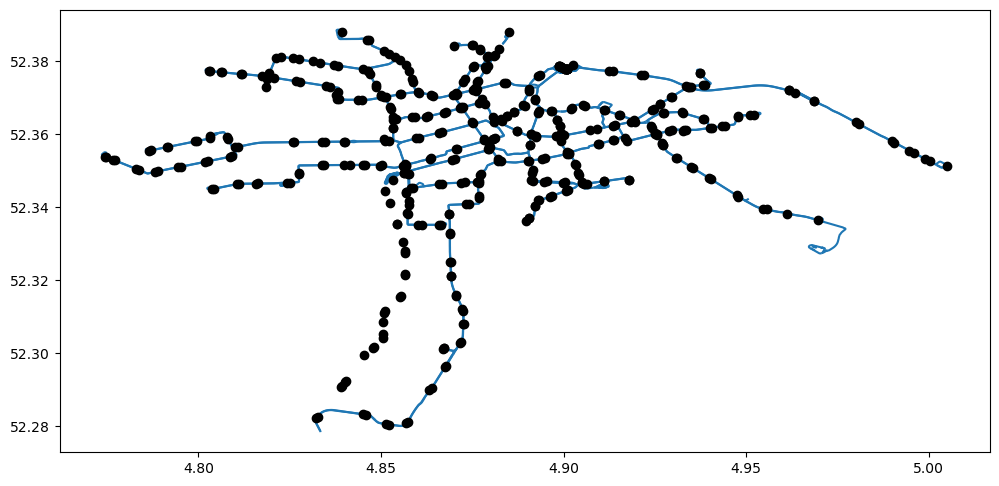

In [11]:
fig, ax = plt.subplots(1, 1,figsize=(12,10))


gpd.GeoDataFrame(edges.copy()).plot(ax=ax,zorder=0)
gpd.GeoDataFrame(stations.copy()).plot(ax=ax,color='black',zorder=1)

In [12]:
stations.to_excel('./am_tram_stations.xlsx',header = True, index = False,sheet_name = 'mydata')  

In [13]:
stations['geo_x'] = stations.geometry.x
stations['geo_y'] = stations.geometry.y

In [14]:
sorted_stations = stations.sort_values(by='geo_x')

In [15]:
stations_drop = sorted_stations [sorted_stations ['name'] != 'Centraal Station'].drop_duplicates(subset=['name'], keep='first')
stations_drop

,osm_id,railway,name,geometry,geo_x,geo_y
314,3296373865,tram_stop,Matterhorn,POINT (4.77450 52.35387),4.774504,52.353869
231,1979187101,tram_stop,Pilatus,POINT (4.77655 52.35301),4.776554,52.353011
232,1979187198,tram_stop,Inaristraat,POINT (4.78295 52.35045),4.782948,52.350449
228,1978110972,tram_stop,Dijkgraafplein,POINT (4.78649 52.35545),4.786493,52.355448
308,3296373458,tram_stop,Ecuplein,POINT (4.78816 52.34969),4.788158,52.349694
...,...,...,...,...,...,...
283,3078345543,tram_stop,Steigereiland,POINT (4.97995 52.36323),4.979951,52.363234
463,10607209062,tram_stop,Vennepluimstraat,POINT (4.98995 52.35806),4.989950,52.358058
271,2677256600,tram_stop,Diemerparklaan,POINT (4.99462 52.35552),4.994625,52.355515
275,2678427771,tram_stop,Lumièrestraat,POINT (4.99902 52.35318),4.999017,52.353181


In [16]:
station_cetralB = sorted_stations[sorted_stations['name'] == 'Centraal Station'].drop_duplicates(subset=['name'], keep='first')
station_cetralB.iloc[0, 2] = 'Centraal Station_B'
station_cetralB

,osm_id,railway,name,geometry,geo_x,geo_y
457,9807478538,tram_stop,Centraal Station_B,POINT (4.89876 52.37860),4.898765,52.378595


In [17]:
station_cetralA = gpd.GeoDataFrame(sorted_stations[sorted_stations['name'] == 'Centraal Station'].iloc[-2]).T
station_cetralA.iloc[0, 2] = 'Centraal Station_A'
station_cetralB

,osm_id,railway,name,geometry,geo_x,geo_y
457,9807478538,tram_stop,Centraal Station_B,POINT (4.89876 52.37860),4.898765,52.378595


In [18]:
df_stations_drop = pd.DataFrame(stations_drop)
df_station_cetralB = pd.DataFrame(station_cetralB)
df_station_cetralA = pd.DataFrame(station_cetralA)
am_tram_stations = pd.concat([df_stations_drop, df_station_cetralB, df_station_cetralA])
am_tram_stations

,osm_id,railway,name,geometry,geo_x,geo_y
314,3296373865,tram_stop,Matterhorn,POINT (4.77450 52.35387),4.774504,52.353869
231,1979187101,tram_stop,Pilatus,POINT (4.77655 52.35301),4.776554,52.353011
232,1979187198,tram_stop,Inaristraat,POINT (4.78295 52.35045),4.782948,52.350449
228,1978110972,tram_stop,Dijkgraafplein,POINT (4.78649 52.35545),4.786493,52.355448
308,3296373458,tram_stop,Ecuplein,POINT (4.78816 52.34969),4.788158,52.349694
...,...,...,...,...,...,...
271,2677256600,tram_stop,Diemerparklaan,POINT (4.99462 52.35552),4.994625,52.355515
275,2678427771,tram_stop,Lumièrestraat,POINT (4.99902 52.35318),4.999017,52.353181
90,388184245,tram_stop,IJburg,POINT (5.00490 52.35113),5.004902,52.351135
457,9807478538,tram_stop,Centraal Station_B,POINT (4.89876 52.37860),4.898765,52.378595


In [19]:
am_tram_stations = am_tram_stations.sort_values(by='geo_y')
am_tram_stations

,osm_id,railway,name,geometry,geo_x,geo_y
47,293884152,tram_stop,Brink,POINT (4.85134 52.28063),4.851337,52.280629
48,293884357,tram_stop,Meent,POINT (4.85697 52.28089),4.856971,52.28089
226,1923365119,tram_stop,Sacharovlaan,POINT (4.83233 52.28218),4.832328,52.282185
46,293883917,tram_stop,Poortwachter,POINT (4.84505 52.28333),4.845053,52.283334
420,6638921572,tram_stop,Sportlaan,POINT (4.86325 52.28979),4.863249,52.289791
...,...,...,...,...,...,...
116,434441260,tram_stop,Van Hallstraat,POINT (4.86985 52.38426),4.869854,52.384264
5,148726445,tram_stop,Van Limburg Stirumplein,POINT (4.87492 52.38442),4.87492,52.384419
277,2941113425,tram_stop,Molenwerf,POINT (4.84616 52.38589),4.846156,52.385889
234,2020414930,tram_stop,Station Sloterdijk,POINT (4.83922 52.38797),4.839217,52.38797


In [20]:
am_tram_name = pd.read_excel(r'./am_tram_name.xlsx')

In [21]:
am_tram_name

,s_name,e_name
0,Muiderpoortstation,Matterhorn
1,Centraal Station_B,Oudenaardeplantsoen
2,Flevopark,Van Hallstraat
3,Centraal Station_A,Station RAI
4,Eerste Marnixdwarsstraat,Amstelveen Stadshart
5,Azartplein,Sloterpark
6,Centraal Station_B,Amstelstation
7,Centraal Station_B,Lambertus Zijlplein
8,Centraal Station_A,Flevopark
9,Centraal Station_B,Dijkgraafplein


In [22]:
df31=pd.merge(am_tram_name,am_tram_stations,how='left',left_on='s_name',right_on='name')
df31=df31.loc[:,['s_name','e_name','geo_x','geo_y']]
df32=pd.merge(df31,am_tram_stations,how='left',left_on='e_name',right_on='name')
df32.loc[:,['s_name','e_name','geo_x_x','geo_y_x','geo_x_y','geo_y_y']]

# df32=pd.merge(am_tram_name,am_tram_stations,how='inner',left_on='e_name',right_on='name')
# df32=df32.loc[:,['e_name','geo_x','geo_y']]
# df3=pd.concat([df31,df32])

,s_name,e_name,geo_x_x,geo_y_x,geo_x_y,geo_y_y
0,Muiderpoortstation,Matterhorn,4.932613,52.360796,4.774504,52.353869
1,Centraal Station_B,Oudenaardeplantsoen,4.898765,52.378595,4.803671,52.344928
2,Flevopark,Van Hallstraat,4.951057,52.365247,4.869854,52.384264
3,Centraal Station_A,Station RAI,4.900983,52.377705,4.890547,52.336905
4,Eerste Marnixdwarsstraat,Amstelveen Stadshart,4.882178,52.383238,4.867093,52.301269
5,Azartplein,Sloterpark,4.937322,52.376613,4.818602,52.372845
6,Centraal Station_B,Amstelstation,4.898765,52.378595,4.91781,52.347427
7,Centraal Station_B,Lambertus Zijlplein,4.898765,52.378595,4.802912,52.377261
8,Centraal Station_A,Flevopark,4.900983,52.377705,4.951057,52.365247
9,Centraal Station_B,Dijkgraafplein,4.898765,52.378595,4.786493,52.355448


In [23]:
df31

,s_name,e_name,geo_x,geo_y
0,Muiderpoortstation,Matterhorn,4.932613,52.360796
1,Centraal Station_B,Oudenaardeplantsoen,4.898765,52.378595
2,Flevopark,Van Hallstraat,4.951057,52.365247
3,Centraal Station_A,Station RAI,4.900983,52.377705
4,Eerste Marnixdwarsstraat,Amstelveen Stadshart,4.882178,52.383238
5,Azartplein,Sloterpark,4.937322,52.376613
6,Centraal Station_B,Amstelstation,4.898765,52.378595
7,Centraal Station_B,Lambertus Zijlplein,4.898765,52.378595
8,Centraal Station_A,Flevopark,4.900983,52.377705
9,Centraal Station_B,Dijkgraafplein,4.898765,52.378595


In [24]:
am_tram_coordinates = pd.DataFrame()
am_tram_coordinates = df32.loc[:,['s_name','e_name','geo_x_x','geo_y_x','geo_x_y','geo_y_y']]
am_tram_coordinates.columns = ['s_name','e_name','s_coordinates_x', 's_coordinates_y', 'e_coordinates_x', 'e_coordinates_y']

In [25]:
am_tram_coordinates

,s_name,e_name,s_coordinates_x,s_coordinates_y,e_coordinates_x,e_coordinates_y
0,Muiderpoortstation,Matterhorn,4.932613,52.360796,4.774504,52.353869
1,Centraal Station_B,Oudenaardeplantsoen,4.898765,52.378595,4.803671,52.344928
2,Flevopark,Van Hallstraat,4.951057,52.365247,4.869854,52.384264
3,Centraal Station_A,Station RAI,4.900983,52.377705,4.890547,52.336905
4,Eerste Marnixdwarsstraat,Amstelveen Stadshart,4.882178,52.383238,4.867093,52.301269
5,Azartplein,Sloterpark,4.937322,52.376613,4.818602,52.372845
6,Centraal Station_B,Amstelstation,4.898765,52.378595,4.91781,52.347427
7,Centraal Station_B,Lambertus Zijlplein,4.898765,52.378595,4.802912,52.377261
8,Centraal Station_A,Flevopark,4.900983,52.377705,4.951057,52.365247
9,Centraal Station_B,Dijkgraafplein,4.898765,52.378595,4.786493,52.355448


In [26]:
am_tram_coordinates.loc[12,'e_coordinates_x'] = 4.8310348
am_tram_coordinates.loc[12,'e_coordinates_y'] = 52.2748113
am_tram_coordinates

,s_name,e_name,s_coordinates_x,s_coordinates_y,e_coordinates_x,e_coordinates_y
0,Muiderpoortstation,Matterhorn,4.932613,52.360796,4.774504,52.353869
1,Centraal Station_B,Oudenaardeplantsoen,4.898765,52.378595,4.803671,52.344928
2,Flevopark,Van Hallstraat,4.951057,52.365247,4.869854,52.384264
3,Centraal Station_A,Station RAI,4.900983,52.377705,4.890547,52.336905
4,Eerste Marnixdwarsstraat,Amstelveen Stadshart,4.882178,52.383238,4.867093,52.301269
5,Azartplein,Sloterpark,4.937322,52.376613,4.818602,52.372845
6,Centraal Station_B,Amstelstation,4.898765,52.378595,4.91781,52.347427
7,Centraal Station_B,Lambertus Zijlplein,4.898765,52.378595,4.802912,52.377261
8,Centraal Station_A,Flevopark,4.900983,52.377705,4.951057,52.365247
9,Centraal Station_B,Dijkgraafplein,4.898765,52.378595,4.786493,52.355448


## Step2-2：calculate the id pairs of stations

In [27]:
am_tram_coordinates_pairs = pd.DataFrame()
am_tram_coordinates_pairs['s_coordinates'] = list(zip(am_tram_coordinates.s_coordinates_x, am_tram_coordinates.s_coordinates_y))
am_tram_coordinates_pairs['e_coordinates'] = list(zip(am_tram_coordinates.e_coordinates_x, am_tram_coordinates.e_coordinates_y))

In [28]:
am_tram_coordinates_pairs

,s_coordinates,e_coordinates
0,"(4.9326128, 52.3607965)","(4.7745043, 52.3538687)"
1,"(4.8987647, 52.3785952)","(4.8036706, 52.3449284)"
2,"(4.9510568, 52.3652467)","(4.8698541, 52.3842644)"
3,"(4.9009826, 52.3777045)","(4.8905473, 52.3369049)"
4,"(4.8821775, 52.383238)","(4.8670933, 52.3012694)"
5,"(4.9373223, 52.3766133)","(4.8186019, 52.3728449)"
6,"(4.8987647, 52.3785952)","(4.9178096, 52.3474274)"
7,"(4.8987647, 52.3785952)","(4.8029118, 52.3772607)"
8,"(4.9009826, 52.3777045)","(4.9510568, 52.3652467)"
9,"(4.8987647, 52.3785952)","(4.7864929, 52.3554481)"


In [29]:
am_tram_id_pairs = id_pairs(am_tram_coordinates_pairs,nodes)
am_tram_id_pairs

,s_id,e_id
0,266,104
1,616,79
2,75,275
3,302,204
4,332,400
5,417,208
6,616,570
7,616,94
8,302,75
9,616,107


## Step3: calculate shortest pathes for all id pairs and visulize the tram map with the used time of each edges

In [30]:
G = create_ground_graph(edges, nodes)

In [31]:
am_tram_shortest_path_pairs = all_shortest_paths(am_tram_id_pairs,edges)
am_tram_shortest_path_pairs

,osm_id,geometry,railway,service,id,from_id,to_id,distance,time,weights,to_from,from_to
4,7046408,"LINESTRING (4.914 52.362, 4.914 52.362, 4.914 ...",tram,None,4,9,10,45.638673,0.002282,45,"(9, 10)","(10, 9)"
70,27028916,"LINESTRING (4.81 52.356, 4.811 52.357, 4.815 5...",tram,NaN,70,98,541,2815.173711,0.140759,2815,"(98, 541)","(541, 98)"
85,27053428,"LINESTRING (4.774 52.354, 4.775 52.354, 4.777 ...",tram,NaN,85,104,311,2910.577944,0.145529,2910,"(104, 311)","(311, 104)"
99,27072682,"LINESTRING (4.853 52.358, 4.853 52.358, 4.854 ...",tram,NaN,99,114,540,128.717409,0.006436,128,"(114, 540)","(540, 114)"
117,27124083,"LINESTRING (4.882 52.364, 4.883 52.364, 4.883 ...",tram,NaN,117,164,21,712.792041,0.035640,712,"(164, 21)","(21, 164)"
...,...,...,...,...,...,...,...,...,...,...,...,...
879,773900799,"LINESTRING (4.905 52.378, 4.905 52.378, 4.905 ...",tram,NaN,879,323,340,4129.954170,0.206498,4129,"(323, 340)","(340, 323)"
951,802397664,"LINESTRING (4.964 52.371, 4.964 52.371, 4.964 ...",tram,yard,951,679,341,334.919105,0.016746,334,"(679, 341)","(341, 679)"
952,802397664,"LINESTRING (4.968 52.369, 4.968 52.369, 4.969 ...",tram,yard,952,341,680,167.455475,0.008373,167,"(341, 680)","(680, 341)"
980,911834558,"LINESTRING (4.97 52.368, 4.97 52.368, 4.971 52...",tram,NaN,980,680,308,2879.737468,0.143987,2879,"(680, 308)","(308, 680)"


In [32]:
duplicate_row_count, am_tram_shortest_path_edges, edges = edges_with_count_weight(am_tram_shortest_path_pairs,edges)
#am_tram_shortest_path_edges, duplicate_row_count

In [33]:
# am_tram_shortest_path_edges.to_excel('./am_tram_shortest_path_edges.xlsx',header = True, index = False) 

<AxesSubplot: >

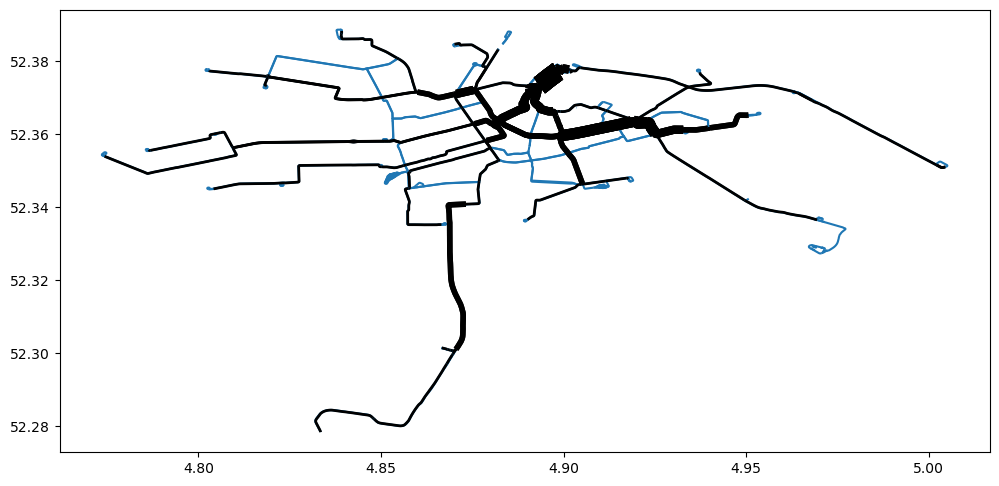

In [34]:
fig, ax = plt.subplots(1, 1,figsize=(12,10))

gpd.GeoDataFrame(edges.copy()).plot(ax=ax,zorder=0)
gpd.GeoDataFrame(am_tram_shortest_path_edges.copy()).plot(ax=ax,color='black',zorder=1,linewidth=(am_tram_shortest_path_edges['count_weight'])*2)

<AxesSubplot: >

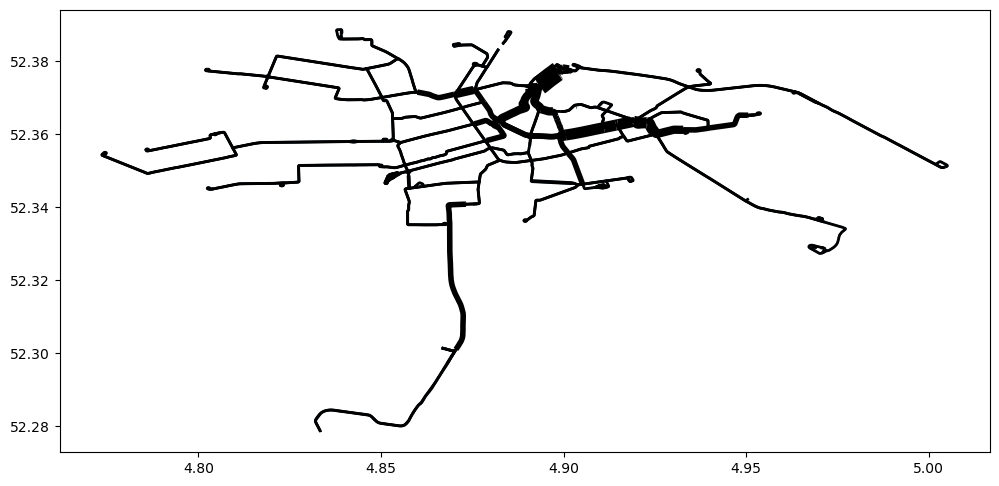

In [35]:
fig, ax = plt.subplots(1, 1,figsize=(12,10))

gpd.GeoDataFrame(edges.copy()).plot(ax=ax,zorder=0)
gpd.GeoDataFrame(edges.copy()).plot(ax=ax,color='black',zorder=1,linewidth=(edges['count_weight'])*2)

## Step4: draw each route with the base map of Amsterdam tram

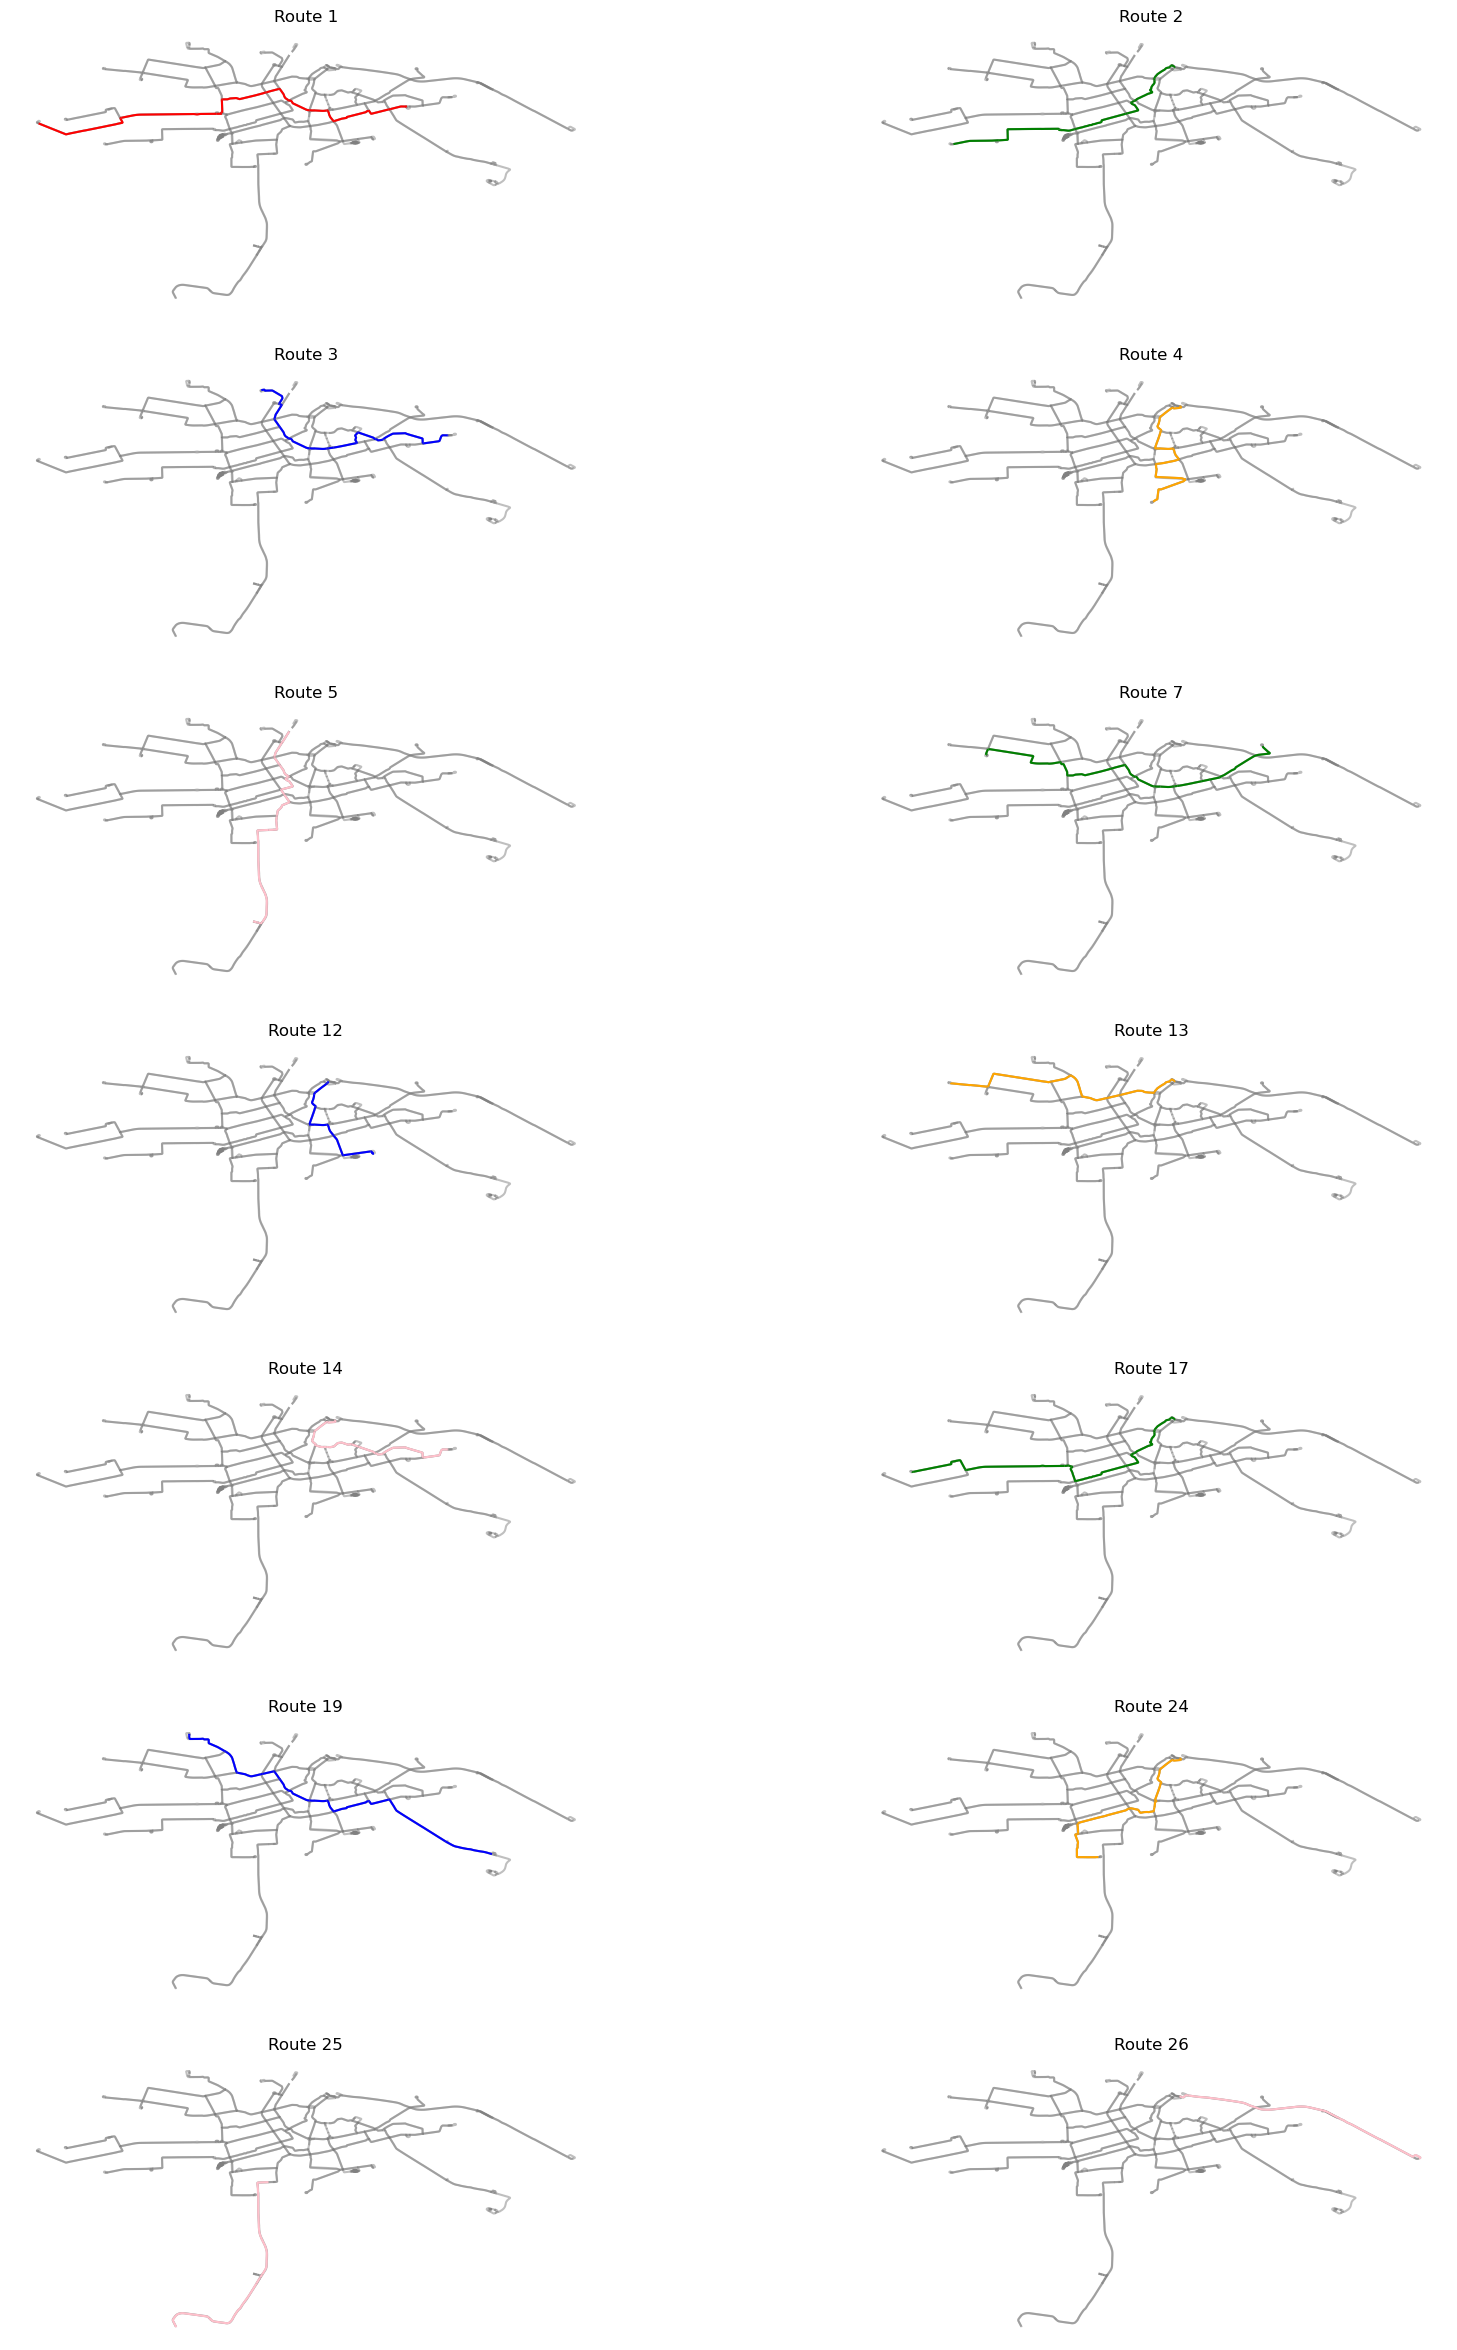

In [36]:
fig, axes = plt.subplots(7, 2,figsize=(20,30))
for i, ax in enumerate(axes.flat):
    if i < 14:
        route, route_weight, route_edges = shortest_path(G, am_tram_id_pairs.loc[i, 's_id'], am_tram_id_pairs.loc[i, 'e_id'], edges, weight = "weights")
    
    if i == 0:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='red')
        ax.set_title('Route 1')
    elif i == 1:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='green')        
        ax.set_title('Route 2')
    elif i == 2:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='blue')
        ax.set_title('Route 3')
    elif i == 3:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='orange')
        ax.set_title('Route 4')
    elif i == 4:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='pink')
        ax.set_title('Route 5')
    elif i == 5:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='green')        
        ax.set_title('Route 7')
    elif i == 6:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='blue')
        ax.set_title('Route 12')
    elif i == 7:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='orange')
        ax.set_title('Route 13')
    elif i == 8:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='pink')
        ax.set_title('Route 14')
    elif i == 9:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='green')        
        ax.set_title('Route 17')
    elif i == 10:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='blue')
        ax.set_title('Route 19')
    elif i == 11:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='orange')
        ax.set_title('Route 24')
    elif i == 12:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='pink')
        ax.set_title('Route 25')
    elif i == 13:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='pink')
        ax.set_title('Route 26')
    else:    
        ax.axis('off')
    
    ax.axis('off')

plt.show()

## Step5: calculate maximum flow for each route of Amsterdam subway

In [37]:
route_capacity = pd.DataFrame({'metro_num': [5.0, 4.0, 7.0, 6.0, 8.0, 6.0, 9.0, 4.0, 3.0, 5.0, 6.0, 7.0, 5.0, 6.0]})

In [ ]:
edges, route_edges, flow_value_dict, flow_value = max_flow(edges, nodes, route_capacity, am_tram_id_pairs, G)

In [ ]:
edges

In [38]:
# 循环的形式实现am_tram_coordinates_pairs，但是有一个问题，缺失的终点站被起始站坐标补齐
am_tram_coordinates_pairs = pd.DataFrame(['s_coordinates_x', 's_coordinates_y', 'e_coordinates_x', 'e_coordinates_y'])
for index, row in am_tram_name.iterrows():
    s_station_name = row['s_name']
    matching_stations1 = am_tram_stations[am_tram_stations['name'] == s_station_name]
    if len(matching_stations1) > 0:
        matching_station = matching_stations1.iloc[0]
        am_tram_coordinates_pairs.loc[index, 's_coordinates_x'] = matching_station['geo_x']
        am_tram_coordinates_pairs.loc[index, 's_coordinates_y'] = matching_station['geo_y'] 

    e_station_name = row['e_name']
    matching_stations2 = am_tram_stations[am_tram_stations['name'] == e_station_name]
    if len(matching_stations2) > 0:
        matching_station = matching_stations2.iloc[0]
        am_tram_coordinates_pairs.loc[index, 'e_coordinates_x'] = matching_station['geo_x']
        am_tram_coordinates_pairs.loc[index, 'e_coordinates_y'] = matching_station['geo_y']


am_tram_coordinates_pairs

,0,s_coordinates_x,s_coordinates_y,e_coordinates_x,e_coordinates_y
0,s_coordinates_x,4.932613,52.360796,4.774504,52.353869
1,s_coordinates_y,4.898765,52.378595,4.803671,52.344928
2,e_coordinates_x,4.951057,52.365247,4.869854,52.384264
3,e_coordinates_y,4.900983,52.377705,4.890547,52.336905
4,NaN,4.882178,52.383238,4.867093,52.301269
5,NaN,4.937322,52.376613,4.818602,52.372845
6,NaN,4.898765,52.378595,4.917810,52.347427
7,NaN,4.898765,52.378595,4.802912,52.377261
8,NaN,4.900983,52.377705,4.951057,52.365247
9,NaN,4.898765,52.378595,4.786493,52.355448


1 Muiderpoortstation,Matterhorn
2 Centraal Station_B,Oudenaardeplantsoen
3 Flevopark,Van Hallstraat
4 Centraal Station_A,Station RAI
5 Eerste Marnixdwarsstraat,Amstelveen Stadshart
7 Azartplein,Sloterpark
12 Centraal Station_B,Amstelstation
13 Centraal Station_B,Lambertus Zijlplein
14 Centraal Station_A,Flevopark
17 Centraal Station_B,Dijkgraafplein
19 Sniep,Station Sloterdijk
24 Centraal Station_A,De Boelelaan/VU
25 Station Zuid,Westwijk
26 Centraal Station_A,IJburg